In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.preprocessing import StandardScaler


train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")

In [44]:
def preprocess(df):
  df.index = pd.to_datetime(df["datetime"])
  df = df["2014-05-01":]
  df = df.reset_index(drop=True)
  
  def weather(x):
    if x.find("快晴"):
      x = 0
    elif x.find("晴れ"):
      x = 1
    elif x.find("曇"):
      x = 2
    elif x.find("薄曇"):
      x = 3
    elif x.find("雨"):
      x = 4
    else:
      x = 5
    return x

  df["days"] = df.index
  df["precipitation"] = df["precipitation"].apply(lambda x : -1 if x=="--" else x).astype(np.float64)
  df["fun"] = df["remarks"].apply(lambda x: 1 if x=="お楽しみメニュー" else 0)
  df["curry"] = df["name"].apply(lambda x : 1 if x.find("カレー")>=0 else 0)
  df["weather"] = df["weather"].apply(weather)
  #df["subuta"] = df["name"].apply(lambda x : 1 if x.find("酢豚")>=0 else 0)
  #df["sp"] = df["remarks"].apply(lambda x : 1 if x==("スペシャルメニュー")>=0 else 0)
  #df["kd"] = df["remarks"].apply(lambda x : 1 if x==("料理長")>=0 else 0)
  
  categorical_cols = ["precipitation", "weather", "days", "fun", "curry", "week", "name", "remarks", "event"]
  
  for cols in categorical_cols:
    if cols in df.columns:
      df[cols] = df[cols].astype("category")
  return df

In [45]:
df_train = preprocess(train)
test["y"] = 0
df_test = preprocess(test)
cols = ["datetime","weather","days","fun","curry","y"]


In [46]:
# ５月１日～９月３０日
df_val = df_train[df_train["datetime"] >="2014-7-28"][cols] # 検証データ
df_tr = df_train[df_train["datetime"] <"2014-7-28" ][cols] # 学習データ

df_val_x = df_val.drop(["y","datetime"],axis=1) # 説明変数の設定
df_tr_x = df_tr.drop(["y","datetime"],axis=1)

df_val["y"] = df_val["y"].astype(int) #エラー修正
df_tr["y"] = df_tr["y"].astype(int) #エラー修正

df_val_y = df_val["y"] # 目的変数の設定
df_tr_y = df_tr["y"]

In [47]:
trains = lgb.Dataset(df_tr_x,df_tr_y)
valids = lgb.Dataset(df_val_x,df_val_y)

In [48]:
fixed_params = {
    "objective":"regression",
    "metric":"mae",
    "min_gain_to_split":0,
    "min_data_in_leaf":0,
    "lambda_l1":0.1,
    "lambda_l2":0.1,
    "max_depth":4,
    "n_estimators":100  
}

In [49]:
model = lgb.train(fixed_params,trains,valid_sets=valids,num_boost_round=1000,callbacks=[lgb.early_stopping(stopping_rounds=100)])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 4
[LightGBM] [Info] Start training from score 68.592593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

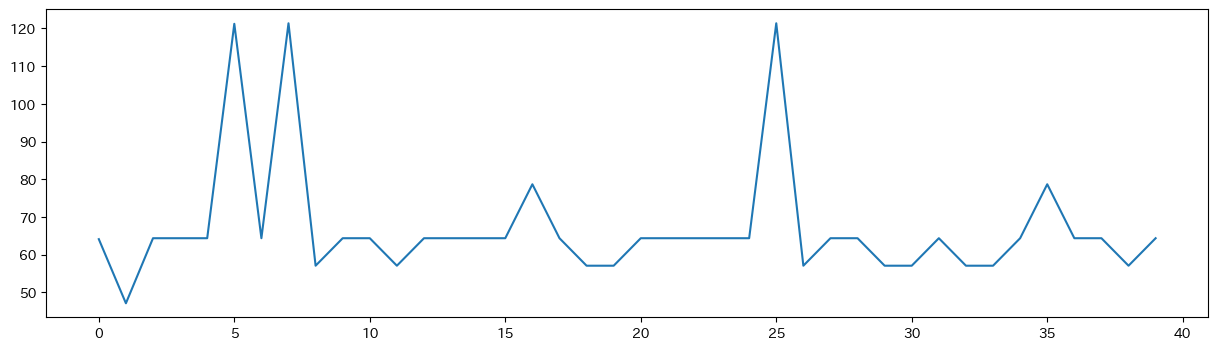

In [50]:
pred = model.predict(df_test[cols].drop(["y","datetime"],axis=1))
plt.figure(figsize=(15,4))
plt.plot(pred)